Enhanced Grayscale Image - Width: 248, Height: 203
Conv2D Layer - conv2d_1
  Weights shape: (3, 3, 1, 32)
  Biases shape: (32,)
  First filter weights (shape (3, 3, 1)):
[[[ 0.10182157]
  [-0.11089481]
  [-0.05227932]]

 [[ 0.08615118]
  [ 0.03482829]
  [ 0.02098948]]

 [[-0.0178056 ]
  [-0.04470384]
  [ 0.02740382]]]
1/1 [==============================] - 0s 53ms/step
Summed filter image shape: (128, 128)


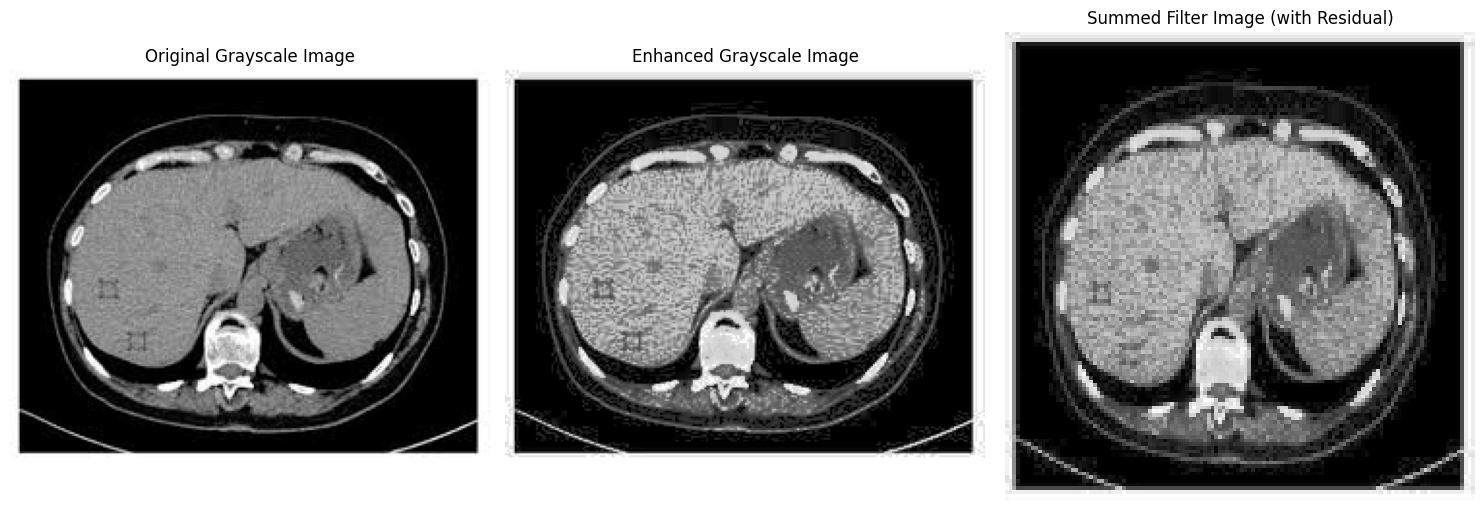

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, Add
import cv2
import tensorflow as tf
import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Clear GPU memory and set memory growth to avoid errors
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

# Set TensorFlow to use CPU only to avoid GPU memory errors
tf.config.set_visible_devices([], 'GPU')

# Load the grayscale image
img_path = '/home/icmr/Pictures/CT.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Enhance the image using histogram equalization
img_enhanced = cv2.equalizeHist(img)

# Check the enhanced image dimensions
height, width = img_enhanced.shape
print(f"Enhanced Grayscale Image - Width: {width}, Height: {height}")

# Resize the image to smaller size (optional step to reduce memory consumption)
resized_img = cv2.resize(img_enhanced, (128, 128))  # Resize to smaller dimensions
resized_height, resized_width = resized_img.shape

# Normalize the resized image (scale pixel values to range [0, 1])
resized_img_normalized = resized_img / 255.0

# Add an extra dimension to represent the batch size (needed for Keras)
# Since the image is grayscale, we only have one channel
img_batch = np.expand_dims(np.expand_dims(resized_img_normalized, axis=-1), axis=0)

# Define the input layer
input_layer = Input(shape=(resized_height, resized_width, 1))

# Apply a single Conv2D layer with 32 filters
conv_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)

# Residual block: Add the input back to the output of the Conv2D layer
residual_output = Add()([input_layer, conv_layer])

# Create the model
model = Model(inputs=input_layer, outputs=residual_output)

# Retrieve and print the weights of the Conv2D layer
layer = model.layers[1]
weights, biases = layer.get_weights()
print(f"Conv2D Layer - {layer.name}")
print(f"  Weights shape: {weights.shape}")  # (filter_height, filter_width, input_channels, output_channels)
print(f"  Biases shape: {biases.shape}")    # (output_channels,)

# Example: Print the weights for the first filter
print(f"  First filter weights (shape {weights[:, :, :, 0].shape}):")
print(weights[:, :, :, 0])  # Weights for the first filter

# Get the filtered output from the model (including the residual connection)
filtered_img = model.predict(img_batch)

# Remove the batch dimension to get the final image shape
filtered_img = filtered_img[0]

# Sum all the feature maps to create a single summed filter image
summed_filter_img = np.sum(filtered_img, axis=-1)
print(f"Summed filter image shape: {summed_filter_img.shape}")

# Display the original, enhanced, and summed filter images
plt.figure(figsize=(15, 5))

# Original grayscale image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')  # Display as grayscale
plt.title('Original Grayscale Image')
plt.axis('off')

# Enhanced grayscale image
plt.subplot(1, 3, 2)
plt.imshow(img_enhanced, cmap='gray')  # Display enhanced image
plt.title('Enhanced Grayscale Image')
plt.axis('off')

# Summed filter image
plt.subplot(1, 3, 3)
plt.imshow(summed_filter_img, cmap='gray')  # Display summed filter output
plt.title('Summed Filter Image (with Residual)')
plt.axis('off')

plt.tight_layout()
plt.show()
